# Color Names

In [1]:
URL = "https://www.toutes-les-couleurs.com/code-couleur-rvb.php"
ENCODING = "ISO-8859-1"

In [2]:
# Effects configured in the ESPHome firmware
EFFECTS = [
    "Nodus",
    "Rainbow",
    "Flicker"
]

## Init

In [3]:
import colorsys
import pathlib
import re
import unicodedata

import bs4
import httpx
import ipywidgets as widgets
import jinja2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

In [ ]:
ROOT = (pathlib.Path.cwd() / "..").resolve()
SOURCE = pathlib.Path.cwd()
CODE = ROOT /"src" / "twitch_crayon"
DOC = (ROOT / ".." / "doc").resolve()

In [5]:
assert all(p.exists() for p in (ROOT, SOURCE, CODE, DOC)), "Some project paths do not exist! Maybe the Notebook was opened in the wrong folder?"

## Scrap colors from website

In [6]:
resp = httpx.get(URL)
content = resp.content.decode(ENCODING)
soup = bs4.BeautifulSoup(content, "html.parser")

In [7]:
rows = soup.select("table[width='510'] tr")

In [8]:
_re_rgb = re.compile(r"^\(\s*(\d{1,3})\s*,\s*(\d{1,3})\s*,\s*(\d{1,3})\s*\)$")

In [9]:
def extract_colors(rows):
    candidates = ([itm.getText(strip=True) for itm in row.select("td")] for row in rows)
    for name, _, rgb, *_ in candidates:
        if m := _re_rgb.match(rgb):
            r, g, b = map(int, m.groups())
            if all(0 <= val <= 255 for val in (r, g, b)):
                h, s, v = colorsys.rgb_to_hsv(r/255, g/255, b/255)
                yield (name, (r, g, b), (h, s, v))

def dedup_colors(colors):
    seen = set()
    for item in colors:
        if item[0] not in seen:
            seen.add(item[0])
            yield item

In [10]:
colors = list(sorted(dedup_colors(extract_colors(rows))))

In [11]:
colors_by_hue = sorted(colors, key=lambda item: (item[2][0], item[2][1]))

In [12]:
def rgb_to_hex(r, g, b):
    return f"#{r:02x}{g:02x}{b:02x}"

In [13]:
def get_df(colors):
    for name, (r, g, b), (h, s, v) in colors:
        yield {
            "name": name,
            "hue": h*360,
            "saturation": s*100,
            "value": v*100,
            "red": r,
            "green": g,
            "blue": b,
            "color": rgb_to_hex(r, g, b)
        }

df = pd.DataFrame(get_df(colors_by_hue))

In [14]:
df["color_maxv"] = df.apply(lambda row: rgb_to_hex(*[int(c*255) for c in colorsys.hsv_to_rgb(row['hue']/360, row['saturation']/100, 1)]), axis=1)

In [15]:
def create_color_visualization(df, with_maxv=False):
    html_content = "<div style='font-family: Arial, sans-serif;'>"
    
    for row in df.itertuples():
        if with_maxv:
            maxvblock = f"<div style='width: 5em; height: 1em; background-color: {row.color_maxv}; border: 1px solid #ccc; margin-right: 10px;'></div>"
        else:
            maxvblock = ""
        html_content += f"""
        <div style='display: flex; align-items: center; margin: 5px 0;'>
            <div style='width: 5em; height: 1em; background-color: {row.color}; border: 1px solid #ccc; margin-right: 10px;'></div>
            {maxvblock}
            <span style='font-size: 14px;'>{row.name}</span>
        </div>
        """
    
    html_content += "</div>"
    return HTML(html_content)

create_color_visualization(df)

## Eliminate colors with too low value

Those colors will not properly display on the light, because value is the
brightness, and brightness will mostly be high. So the light will display
a version of the color with a higher value, which means the color output
will not match the color that was intended when picked by its name.

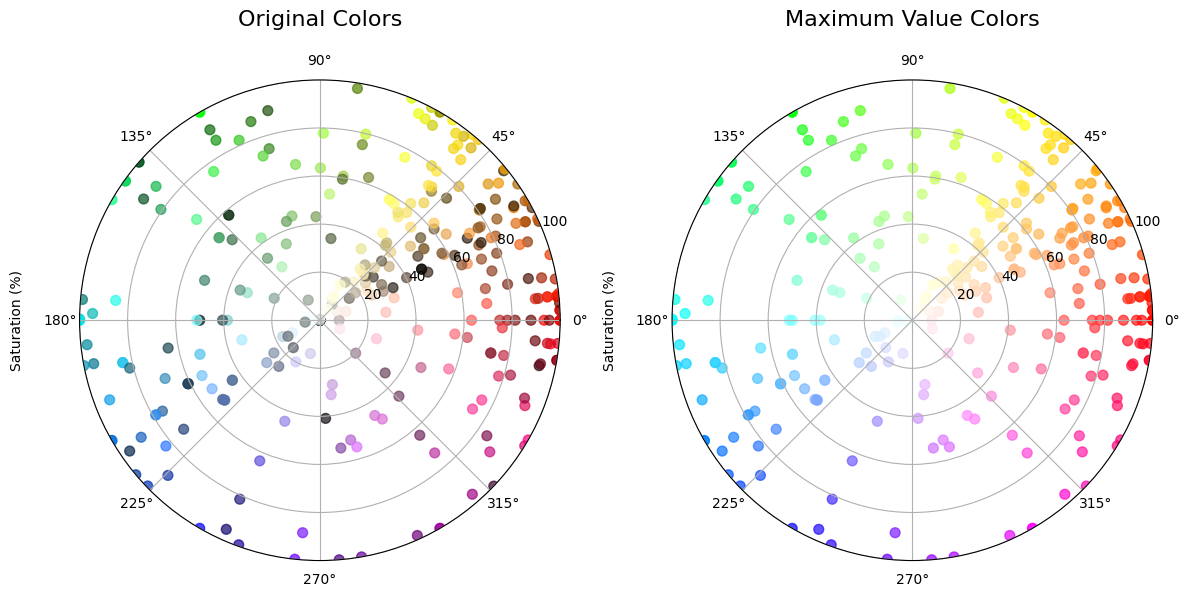

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(projection='polar'))

theta = np.radians(df["hue"])
r = df["saturation"]

# Left plot - original colors
scatter1 = ax1.scatter(theta, r, c=df['color'], s=50, alpha=0.7)
ax1.set_ylim(0, 100)
ax1.set_title('Original Colors', pad=20, fontsize=16)
ax1.set_ylabel('Saturation (%)', labelpad=40)
ax1.grid(True)

# Right plot - maximum value colors
scatter2 = ax2.scatter(theta, r, c=df['color_maxv'], s=50, alpha=0.7)
ax2.set_ylim(0, 100)
ax2.set_title('Maximum Value Colors', pad=20, fontsize=16)
ax2.set_ylabel('Saturation (%)', labelpad=40)
ax2.grid(True)

plt.tight_layout()
plt.show()

In [17]:
df_filtered = df[df.value >= 80]

def create_interactive_plot(min_value):
    global df_filtered
    df_filtered = df[df.value >= min_value]
    items = df_filtered.shape[0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(projection='polar'))
    
    theta = np.radians(df_filtered["hue"])
    r = df_filtered["saturation"]
    
    # Left plot - original colors
    scatter1 = ax1.scatter(theta, r, c=df_filtered['color'], s=50, alpha=0.7)
    ax1.set_ylim(0, 100)
    ax1.set_title(f'Filtered at {min_value}% ({items} items)', pad=20, fontsize=16)
    ax1.set_ylabel('Saturation (%)', labelpad=40)
    ax1.grid(True)
    
    # Right plot - maximum value colors
    scatter2 = ax2.scatter(theta, r, c=df_filtered['color_maxv'], s=50, alpha=0.7)
    ax2.set_ylim(0, 100)
    ax2.set_title('Maximum Value Colors', pad=20, fontsize=16)
    ax2.set_ylabel('Saturation (%)', labelpad=40)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Create slider widget
min_value_slider = widgets.IntSlider(
    value=75,
    min=0,
    max=100,
    step=1,
    description='Min Value (%):',
    style={'description_width': 'initial'}
)

# Create interactive widget
interactive_plot = widgets.interactive(create_interactive_plot, min_value=min_value_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=75, description='Min Value (%):', style=SliderStyle(description_width='i…

In [18]:
create_color_visualization(df_filtered, with_maxv=True)

## Group too-close colors

In [19]:
def polar_distance(hue1, sat1, hue2, sat2):
    """Calculate distance between two points in polar coordinates"""
    delta_hue = np.radians(hue1 - hue2)
    return np.sqrt(sat1**2 + sat2**2 - 2 * sat1 * sat2 * np.cos(delta_hue))

def find_color_groups(df, threshold=5):
    """Group colors that are too close to each other"""
    n = len(df)
    groups = []
    used_indices = set()
    
    for i in range(n):
        if i in used_indices:
            continue
            
        group = [i]
        used_indices.add(i)
        
        for j in range(i + 1, n):
            if j in used_indices:
                continue
                
            dist = polar_distance(
                df.iloc[i]['hue'], df.iloc[i]['saturation'],
                df.iloc[j]['hue'], df.iloc[j]['saturation']
            )
            
            if dist < threshold:
                group.append(j)
                used_indices.add(j)
        
        if len(group) > 1:  # Only keep groups with multiple colors
            groups.append(group)
    
    return groups


In [20]:
def create_colorgroup_visualization(df, groups):
    ngroups = len(groups)
    nduplicates = sum(len(group) for group in groups)
    nunique = len(df) - nduplicates
    remaining = ngroups + nunique
    html_content = f"""<div style='font-family: Arial, sans-serif;'>
    <h2>Color Groups: ({ngroups})</h2>
    <p>Unique colors not in any group: {nunique}</p>
    <p>Total remaining colors once merged: {remaining}</p>
    """
    
    for i, group in enumerate(groups, 1):
        html_content += f"<h3>Group {i}:</h3>"
        for idx in group:
            row = df.iloc[idx]
            html_content += f"""
            <div style='display: flex; align-items: center; margin: 5px 0;'>
                <div style='width: 5em; height: 1em; background-color: {row.color_maxv}; border: 1px solid #ccc; margin-right: 10px;'></div>
                <span style='font-size: 14px;'>{row['name']}</span>
            </div>
            """
    html_content += "</div>"
    return HTML(html_content)

In [21]:
color_groups = []

def visu_color_groups(threshold=15):
    global color_groups
    # Find groups of close colors
    color_groups = find_color_groups(df_filtered, threshold=threshold)
    display(create_colorgroup_visualization(df_filtered, color_groups))

# Create slider widget
threshold_slider = widgets.IntSlider(
    value=10,
    min=0,
    max=30,
    step=1,
    description='Confusion Threshold:',
    style={'description_width': 'initial'}
)

interactive_select = widgets.interactive(visu_color_groups, threshold=threshold_slider)
display(interactive_select)

interactive(children=(IntSlider(value=10, description='Confusion Threshold:', max=30, style=SliderStyle(descri…

In [22]:
# Get indices of colors that are in groups
grouped_indices = set()
for group in color_groups:
    grouped_indices.update(group)

# Select colors that are NOT in any group using iloc positions
df_unique = df_filtered.iloc[~df_filtered.index.isin([df_filtered.iloc[idx].name for group in color_groups for idx in group])]

# Display the unique colors
create_color_visualization(df_unique, with_maxv=True)

In [23]:
select_in_group = {
    1:  "Blanc",
    2:  "Terracotta",
    3:  "Rouge",
    4:  "Rouge vermillon",
    5:  "Pêche",
    6:  "Blanc écru",
    7:  "Carotte",
    8:  "Tangerine",
    9:  "Abricot",
    10: "Vénitien",
    11: "Vanille",
    12: "Melon",
    13: "Beige",
    14: "Maïs",
    15: "Aurore",
    16: "Miel",
    17: "Or",
    18: "Jaune paille",
    19: "Soufre",
    20: "Jaune",
    21: "Chrome",
    22: "Vert pistache",
    23: "Vert lichen",
    24: "Vert",
    25: "Vert émeraude",
    26: "Cyan",
    27: "Bleu céleste",
    28: "Azur clair",
    29: "Fumée",
    30: "Bleu roi",
    31: "Pervenche",
    32: "Parme",
    33: "Lilas",
    34: "Mauve",
    35: "Magenta fushia",
    36: "Rose bonbon",
    37: "Framboise",
    38: "Vermeil",
}

In [24]:
# Extract rows where the name column matches values in select_in_group
df_selected = df_filtered[df_filtered['name'].isin(select_in_group.values())]

# Display the selected colors
create_color_visualization(df_selected, with_maxv=True)

In [25]:
df_merged = pd.concat([df_unique, df_selected]).sort_values(by='hue').reset_index(drop=True)
create_color_visualization(df_merged, with_maxv=True)

## Refine names

In [26]:
# Extract compound names (multiple words or hyphenated)
compound_names = []

for name in df_merged['name']:
    # Check if name contains spaces (multiple words) or hyphens
    if ' ' in name or '-' in name:
        compound_names.append(name)

# Print one per line
for name in compound_names:
    print(name)

Rouge vermillon
Rose thé
Ocre jaune
Jaune paille
Beurre frais
Blanc d'ivoire
Blanc écru
Vert chartreuse
Vert pistache
Vert lime
Vert anis
Vert absinthe
Vert amande
Vert prairie
Vert lichen
Vert pomme
Vert perroquet
Menthe à l'eau
Vert émeraude
Vert opaline
Aigue-marine
Bleu céleste
Azur clair
Bleu céruléen
Bleu roi
Bleu ciel
Bleu charrette
Bleu électrique
Bleu majorelle
Bleu persan
Rouge-violet
Magenta fushia
Rose bonbon
Rose balais
Rouge rubis
Rose dragée


In [27]:
name_map = {
    "Rouge vermillon": "Vermillon",
    "Rose thé":        "Barbie",
    "Ocre jaune":      "Ocre",
    "Jaune paille":    "Paille",
    "Beurre frais":    "Beurre",
    "Blanc d'ivoire":  "Ivoire",
    "Blanc écru":      "Écru",
    "Vert chartreuse": "Chartreuse",
    "Vert pistache":   "Pistache",
    "Vert lime":       "Lime",
    "Vert anis":       "Anis",
    "Vert absinthe":   "Absinthe",
    "Vert amande":     "Amande",
    "Vert prairie":    "Prairie",
    "Vert lichen":     "Lichen",
    "Vert pomme":      "Pomme",
    "Vert perroquet":  "Perroquet",
    "Menthe à l'eau":  "Menthe",
    "Vert émeraude":   "Émeraude",
    "Vert opaline":    "Opaline",
    "Aigue-marine":    "Aiguemarine",
    "Bleu céleste":    "Céleste",
    "Azur clair":      "Auvergne",
    "Bleu céruléen":   "Céruléen",
    "Bleu roi":        "Roi",
    "Bleu ciel":       "Ciel",
    "Bleu charrette":  "Charrette",
    "Bleu électrique": "Électrique",
    "Bleu majorelle":  "Majorelle",
    "Bleu persan":     "Persan",
    "Rouge-violet":    "Violet",
    "Magenta fushia":  "Fushia",
    "Rose bonbon":     "Bonbon",
    "Rose balais":     "Macgowan",
    "Rouge rubis":     "Rubis",
    "Rose dragée":     "Dragée",
}

In [28]:
df_renamed = df_merged.copy()
df_renamed['newname'] = df_renamed['name'].apply(lambda name: name_map.get(name, name))

In [29]:
# Find duplicate names in the 'newname' column (excluding None values)
duplicates = df_renamed[df_renamed['newname'].notna()]['newname'].value_counts()
duplicates = duplicates[duplicates > 1]

if len(duplicates) > 0:
    print("Warning: Duplicate names found in 'newname' column:")
    for name, count in duplicates.items():
        print(f"  '{name}': {count} occurrences")
        # Show which original names map to this duplicate
        original_names = df_renamed[df_renamed['newname'] == name]['name'].tolist()
        print(f"    Original names: {original_names}")
else:
    print("No duplicate names found in 'newname' column")

No duplicate names found in 'newname' column


In [30]:
df_renamed['final_name'] = df_renamed['newname'].apply(lambda x: unicodedata.normalize('NFD', x).encode('ascii', 'ignore').decode('utf-8').capitalize())

In [31]:
selected_colors = {}

for _, row in df_renamed.sort_values('final_name').iterrows():
    if pd.notna(row['final_name']):
        name = row['final_name']
        r, g, b = colorsys.hsv_to_rgb(row['hue']/360, row['saturation']/100, 1)
        selected_colors[name] = (int(r*255), int(g*255), int(b*255))

for name, rgb in selected_colors.items():
    print(f"'{name}': ({rgb[0]}, {rgb[1]}, {rgb[2]}),")

'Abricot': (255, 139, 53),
'Absinthe': (146, 255, 87),
'Aiguemarine': (124, 255, 255),
'Amande': (169, 255, 140),
'Anis': (174, 255, 93),
'Aurore': (255, 202, 96),
'Auvergne': (122, 220, 255),
'Azur': (0, 127, 255),
'Azurin': (169, 234, 255),
'Barbie': (255, 134, 106),
'Beige': (255, 220, 161),
'Beurre': (255, 244, 141),
'Blanc': (255, 255, 255),
'Bleu': (0, 0, 255),
'Bonbon': (255, 67, 161),
'Carotte': (255, 106, 28),
'Celeste': (41, 211, 255),
'Ceruleen': (16, 172, 255),
'Charrette': (182, 208, 255),
'Chartreuse': (200, 255, 51),
'Chrome': (237, 255, 12),
'Ciel': (119, 181, 255),
'Citron': (247, 255, 60),
'Corail': (255, 68, 1),
'Cyan': (0, 255, 255),
'Dragee': (255, 191, 210),
'Ecru': (255, 255, 224),
'Electrique': (44, 117, 255),
'Emeraude': (1, 255, 104),
'Flave': (255, 255, 167),
'Framboise': (255, 56, 92),
'Fumee': (211, 238, 255),
'Fushia': (255, 0, 133),
'Givre': (156, 255, 255),
'Grenadine': (255, 61, 68),
'Incarnadin': (255, 150, 160),
'Indigo': (124, 28, 255),
'Ivoire': (25

## Export

In [32]:
PY_TPL = SOURCE / "colors.py.j2"
PY_OUT = CODE / "colors.py"
with PY_TPL.open('r') as f:
    template = jinja2.Template(f.read())
rendered = template.render(selected_colors=selected_colors, effects=EFFECTS)
with PY_OUT.open('w') as f:
    f.write(rendered)

In [33]:
MD_TPL = SOURCE / "USAGE.md.j2"
MD_OUT = DOC / "USAGE.md"

colors = df_renamed.sort_values(by=['hue', 'saturation'])[['final_name', 'color_maxv']].to_records(index=False)

with MD_TPL.open('r') as f:
    template = jinja2.Template(f.read())
rendered = template.render(colors=colors)
with MD_OUT.open('w') as f:
    f.write(rendered)